## Caso de estudio 1: Control del ángulo del motor en variables de estado

Dadas las ecuaciones del motor de corriente continua con las mediciones experimentales detalladas en la Fig. 1, se sabe que las ecuaciones son:

1. $$ \frac{di_a}{dt} = -\frac{R_A}{L_{AA}}i_a - \frac{K_m}{L_{AA}}\omega_r + \frac{1}{L_{AA}}v_a $$
2. $$ \frac{d\omega_r}{dt} = \frac{K_i}{J}i_a - \frac{B_m}{J}\omega_r - \frac{1}{J}T_L $$
3. $$ \frac{d\theta_t}{dt} = \omega_r $$

---

**Ítem [1]**  
Empleando los parámetros hallados en el Trabajo Práctico Nº1 para el Motor CC, implementar un sistema en variables de estado que controle el ángulo del motor, para consignas de π/2 y –π/2 cambiando cada 5 segundos y que el $ T_L $ es el descripto en la planilla de datos, comparando el desempeño con el obtenido con el PID digital del TP Nº1. Hallar el valor de integración Euler adecuado.

**Objetivo:** acelerar la dinámica del controlador verificando el resultado con las curvas del archivo `.xls` adjunto.

- **a.** Evitando que la tensión supere los 5 Volts en valor absoluto, especificar el tiempo de muestreo necesario para que el controlador cumpla el objetivo.  
- **b.** Asumiendo que no puede medirse directamente la corriente, **pero sí la velocidad y el ángulo**, proponer un controlador que logre el objetivo.  
- **c.** Determinar el efecto de la no linealidad en la acción de control, descripta en la Fig. 2, y verificar cuál es el máximo valor admisible de esa no linealidad.

![Caso 1 - imagen](extras/case1.png)


In [5]:
# !pip install numpy pandas matplotlib scipy openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import place_poles

 ### 1. Modelo del Motor CC
 La representación en espacio de estados es:
 $$
 \dot{x} = A x + B u, \quad y = C x
 $$
 donde:
 $$
 x = \begin{bmatrix} i_a \\ \omega_r \\ \theta_r \end{bmatrix}, \quad
 u = \begin{bmatrix} v_a \\ T_L \end{bmatrix}, \quad
 y = \theta_r
 $$
 $$
 A = \begin{bmatrix}
 -\frac{R_A}{L_{AA}} & -\frac{K_m}{L_{AA}} & 0 \\
 \frac{K_i}{J} & -\frac{B_m}{J} & 0 \\
 0 & 1 & 0
 \end{bmatrix}, \quad
 B = \begin{bmatrix}
 \frac{1}{L_{AA}} & 0 \\
 0 & -\frac{1}{J} \\
 0 & 0
 \end{bmatrix}, \quad
 C = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}
 $$

In [79]:
# ------------------- Parámetros del Sistema -------------------
# Parámetros del motor (identificados experimentalmente)
Ra = 2.2781228953606902
Laa = 0.005187184919244553
Ki = 0.2618711775870197
Jm = 0.002848787974411428
Bm = 0.0014279727330389095
Km = 0.2499435593696499


# Parámetros del motor [originales]
# Ra = 2.27        # Resistencia de armadura [Ohm]
# Laa = 0.0047     # Inductancia de armadura [H]
# Ki = 0.25        # Constante de torque [N⋅m/A]
# Km = 0.25        # Constante de fuerza contraelectromotriz [V⋅s/rad]
# Bm = 0.00131     # Coeficiente de fricción viscosa [N⋅m⋅s/rad]
# Jm = 0.00233     # Momento de inercia [kg⋅m²]

# Ra=2.27;Laa=0.0047;Ki=0.25;Km=0.25;Bm=0.00131;Jm=0.00233; 

# Matrices del sistema en espacio de estados
A = np.array([
    [-Ra/Laa,   -Km/Laa,  0],
    [Ki/Jm,     -Bm/Jm,   0],
    [0,         1,        0]
])
B_va = np.array([[1/Laa], [0], [0]])
B_torque = np.array([[0], [-1/Jm], [0]])
B = np.hstack((B_va, B_torque))

C = np.array([[0, 0, 1]])

C_obs = np.array([[0, 1, 0],    # Observa la velocidad angular
              [0, 0, 1]])   # Observa el ángulo


# autovalores del sistema
autovalores = np.linalg.eigvals(A)
print(f"Autovalores del sistema: {autovalores}") 

# tiempo de integracion
t_int = np.log(0.95) / np.min(np.real(autovalores))
# redondear a 4 decimales
t_int = round(t_int, 5)
print(f"Tiempo de integración: {t_int} s")
 

Autovalores del sistema: [   0.          -10.84191401 -428.84223831]
Tiempo de integración: 0.00012 s


Vamos a definir una funcion auxiliar, para realizar las simulaciones del sistema (más rapidamente que el controlador)

Simular con subpasos dentro de `sim_motor` permite capturar las dinámicas rápidas del sistema sin hacer más lenta toda la simulación (con controlador y observador). Mejoramos la precisión numérica y la estabilidad, manteniendo el controlador a un ritmo de muestreo más alto.  


In [80]:
def sim_motor(dt, x0, u, pasos_min=10):
    """
    Simula el sistema dx/dt = A x + B u durante dt,
    usando subpasos internos calculados en base a la dinámica más rápida del sistema.

    Parámetros:
    - dt_externo: paso externo de integración [s]
    - x0: estado actual (3x1)
    - u: entrada actual (2x1)
    Retorna:
    - x_f: estado al final de dt
    """
    h = t_int # calculado en base a la dinámica más rápida del sistema
    x = x0.copy()

    n_subpasos = int(np.ceil(dt / h))

 
    # Integrar con subpasos (Euler)
    for _ in range(n_subpasos):
        dx = A @ x + B @ u 
        x += h * dx

    return x


## Integrador para la realimentación de estados
Para esto, antes agregamos el integrador (para que el error converja a cero)



El sistema ampliado se convierte en:

$$
\begin{bmatrix}
\dot{x}(t) \\
\dot{\xi}(t)
\end{bmatrix}
=
\begin{bmatrix}
A & 0 \\
-C & 0
\end{bmatrix}
\begin{bmatrix}
x(t) \\
\xi(t)
\end{bmatrix}
+
\begin{bmatrix}
B \\
0
\end{bmatrix}
u(t)

$$


Donde:

$$

A_a = \begin{bmatrix} A & 0 \\ -C & 0 \end{bmatrix}, \quad

x_a = \begin{bmatrix} x \\ \xi \end{bmatrix}

B_a = \begin{bmatrix} B \\ 0 \end{bmatrix}, \quad

E_a = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad
$$


In [81]:
# Primero agregamos el integrador y hacemos la matriz aumentada
A_aug = np.vstack((np.hstack((A, np.zeros((3,1)))), 
                   np.hstack((-C[0,:], 0)) ))

B_aug = np.vstack((B_va, 0))
C_aug = np.hstack((C, np.array([[0]])))

# polos deseados
polos_deseados = np.array([-300, -50, -15, -10])

# calculamos la ganancia del controlador
K_aug = place_poles(A_aug, B_aug, polos_deseados).gain_matrix

print(f"Ganancia K_aug: {K_aug}")

Ganancia K_aug: [[  -0.33552866    1.08812225   24.12349763 -126.96577702]]


# Construiremos el observador de Luenberger

Tenemos 2 caminos para diseñar el observador:

1. Transformamos la matriz en la forma canonica observable, luego despejar para calcular la ganancia Ko (L)
2. Aprovechar el concepto de dualidad para hallar Ko(L)

En este caso iremos por la segunda opción. Ya que nos permite transformar el problema de diseño del observador en un problema de control dual.

Para el sistema original:
$$
\begin{align}
\dot{x} &= Ax + Bu \\
y &= Cx
\end{align}
$$

El sistema dual es:
$$
\begin{align}
\dot{x} &= A^T x + C^T u \\
y &= B^T x
\end{align}
$$

Donde:
 - $A_{dual} = A^T$ (transpuesta de $A$)
 - $B_{dual} = C^T$ (transpuesta de $C$)
 - $C_{dual} = B^T$ (transpuesta de $B$)

Si el sistema original es observable, el sistema dual es controlable, y viceversa.
Esto nos permite usar las técnicas de control (como ubicación de polos) para encontrar la ganancia del observador L (Ko)

La ganancia del observador L será la transpuesta de la ganancia K del controlador del sistema dual:
$L = K^T$


In [82]:
# Verificamos que el sistema original sea observable
O = np.hstack((B, A@B, (A)**2 @B))
rank_O = np.linalg.matrix_rank(O)

# Si el rango es igual a la dimensión del sistema, el sistema es observable
if rank_O == A.shape[0]:
    print("El sistema es observable")
else:
    print("El sistema no es observable")



# Sistema dual
A_dual = A.T
B_dual = C_obs.T
C_dual = B_va.T

# Chequeo de dimensiones (no es necesario, lo dejo para debugging)
print("Dimensiones:")
print(f"A_dual: {A_dual.shape}")
print(f"B_dual: {B_dual.shape}")
print(f"C_dual: {C_dual.shape}")
 
print(f"\nA_dual\n: {A_dual}")


El sistema es observable
Dimensiones:
A_dual: (3, 3)
B_dual: (3, 2)
C_dual: (1, 3)

A_dual
: [[-439.18289608   91.92371631    0.        ]
 [ -48.18481763   -0.50125623    1.        ]
 [   0.            0.            0.        ]]


Elegimos los polos del observador de manera que el sistema sea estable y que el error converja a cero en el tiempo deseado. Evitamos que el observador sea demasiado rapido, para que no se vuelva inestable.


In [84]:
# Calculamos la dinámica más rápida del sistema original
max_pole = np.max(np.abs(np.linalg.eigvals(A)))

print(max_pole)
# Calculamos los polos del observador de manera que sea 4 veces más rapido que el sistema
# polos_observador = polos_sistema * 2 
# print(polos_observador)
 

 # Para este caso, consideramos que el tiempo de muestreo es 0.001 s
t_muestreo = 0.001

print("En teoría, los polos del observador deberían ser mayores a ", 10*max_pole)

# Se hace caso a la sugerencia de la catedra, y se eligen los siguientes polos 
# para el observador

polos_observador = np.array([-330, -200, -220]) 


428.84223830964004
En teoría, los polos del observador deberían ser mayores a  4288.4223830964


### Procedimiento para calcular la ganancia de realimentación

Recordemos que la matriz que determina la dinamica a lazo cerrado es:

$$ 
 A_{cl} = A_{dual} - B_{dual} \cdot K
$$
 
La ganancia K (valores de $k1$, $k2$, $k3$, $k4$) se calcula igualando los coeficientes del polinomio caracteristico del sistema en lazo cerrado con los coeficientes del polinomio deseado.

$$
det(sI - Acl) = det(sI - (A_{dual} - B_{dual} \cdot K)) = 0
$$

El polinomio caracteristico deseado es:

$$
(s - p_1)(s - p_2)(s - p_3) = s^3 + a_2s^2 + a_1s + a_0 = 0
$$

donde $p_1$, $p_2$ y $p_3$ son los polos deseados del observador en terminos de $k1$, $k2$, $k3$, $k4$ (K).

Los coeficientes $a_i$ se obtienen expandiendo el polinomio:

$$
a_2 = -(p_1 + p_2 + p_3)
$$

$$
a_1 = p_1p_2 + p_1p_3 + p_2p_3
$$

$$
a_0 = -p_1p_2p_3
$$


Todo esto se puede sintetizar con la siguiente función en python: 

In [85]:
 

 

K = place_poles(A_dual, B_dual, polos_observador).gain_matrix  

print(f"K: {K}")

 



K: [[ 2.35905953e+02  9.03158664e+01  1.00921192e+00]
 [-7.95383578e-02  5.37443373e-02  2.19999981e+02]]


Debemos recordar que la ganancia K es la transpuesta de la ganancia L del observador, por lo que debemos tomar la transpuesta de la ganancia K para obtener la ganancia L.

In [86]:
L = K.T
print(f"Ganancia L del observador: {L}")

Ganancia L del observador: [[ 2.35905953e+02 -7.95383578e-02]
 [ 9.03158664e+01  5.37443373e-02]
 [ 1.00921192e+00  2.19999981e+02]]


Ahora verificamos que los polos del observador sean los deseados, recordando que la matriz que determina la dinamica del observador es:
$$
A_{observador} = A - L \cdot C
$$

In [88]:
# Verificamos las dimensiones de A, L y C


polos_observador_obtenidos = np.linalg.eigvals(A - L @ C_obs)
print(f"Polos del observador obtenidos: {polos_observador_obtenidos}")

# El error debería converger a cero en :
tiempo_convergencia_estimado = 4 / np.min(polos_observador_obtenidos)
print(f"Tiempo estimado de convergencia del error: {tiempo_convergencia_estimado:.4f} s")



Polos del observador obtenidos: [-330. -200. -220.]
Tiempo estimado de convergencia del error: -0.0121 s


## Implementación y comparación con las mediciones

Se procerá a comparar los resultados medidos con los resultados observados.

In [89]:
# Carga del archivo .xlsx
datos = pd.read_excel('./data/Curvas_Medidas_Motor_2025_v.xlsx')

# Extraer columnas relevantes
t_med = datos['Tiempo [Seg.]'].values        
va_med = datos['Tensión [V]'].values      
ia_med = datos['Corriente en armadura [A]'].values  
wr_med = datos['Velocidad angular [rad /seg]'].values 
tl_med = datos['Torque'].values  


Simulamos el modelo estimado (TP1)

In [91]:
# Tiempo de muestreo
dt = t_med[1] - t_med[0]

# Inicialización de variables
N = len(t_med)
x = np.zeros((3, N))  # [ia, w, theta]

# Simulación del modelo real
for k in range(N - 1):
    u_k = np.array([va_med[k], tl_med[k]])  # entrada en t_k
    dx = A @ x[:, k] + B @ u_k
    x[:, k+1] = x[:, k] + dt * dx


Simulamos el observador:

In [155]:
# Inicialización del observador
x_hat = np.zeros((3, N))  # estimación de [ia, w, theta]
error_obs = np.zeros((3, N))

for k in range(N - 1):
    u_k = np.array([va_med[k], tl_med[k]])

    y_k = C_obs @ x[:, [k]]            # ahora y es un vector de 2 elementos
    y_hat_k = C_obs @ x_hat[:, [k]]  # también vector

 

    # verificamos que las dimensiones sean correctas
 
    # Observador de Luenberger
    dx_hat = A @ x_hat[:, [k]] + B @ u_k + L @ (y_k - y_hat_k) 
 
    print(f"Dimensiones de dx_hat: {dx_hat.shape}")
    print(f"Dimensiones de x_hat[:, [k]]: {x_hat[:, [k]].shape}")
    print(f"Dimensiones de  A @ x_hat[:, [k]]: {A @x_hat[:, [k]].shape}")

    x_hat[:, [k+1]] = x_hat[:, [k]] + dt * dx_hat
    error_obs[:, k] = x[:, k] - x_hat[:, k]


Dimensiones de dx_hat: (3, 3)
Dimensiones de x_hat[:, [k]]: (3, 1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

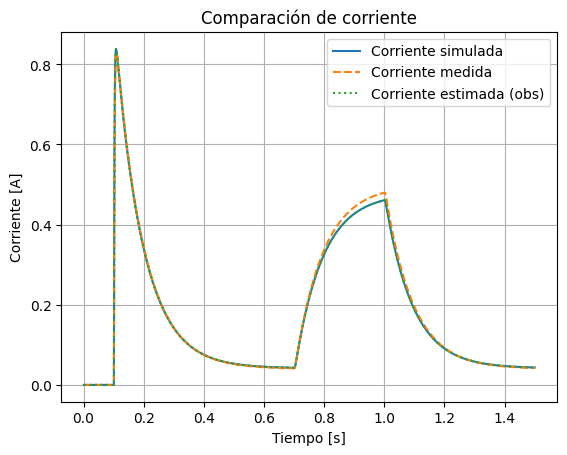

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t_med, x[0], label='Corriente simulada')
plt.plot(t_med, ia_med, label='Corriente medida', linestyle='--')
plt.plot(t_med, x_hat[0], label='Corriente estimada (obs)', linestyle=':')
plt.title("Comparación de corriente")
plt.xlabel("Tiempo [s]")
plt.ylabel("Corriente [A]")
plt.legend()
plt.grid()

# Simulación del sistema con Controlador + Observador


In [25]:
t_final = 10
dt = 0.001
N = int(t_final / dt)

# condiciones iniciales 

X = np.zeros((3, 1))       # Estado real del sistema: [ia, ω, θ]
x_hat = np.zeros((3, 1))   # Estado estimado por el observador
int_error = 0                    # Integrador del error
TL_max = 0.12              # Torque máximo de perturbación


e = np.zeros(N)            # Error entre referencia y salida real
e_obs = np.zeros((3, N))   # Error entre estado real y estimado por el observador
x1, x2, x3 = np.zeros(N), np.zeros(N), np.zeros(N)  # Estados reales
acc = np.zeros(N)          # Entrada de control (tensión)
TL_hist = np.zeros(N)      # Torque aplicado
theta_ref_hist = np.zeros(N)  # Historial de referencia de posición

In [27]:
def aplicar_zona_muerta(u, limite=0.5):
    if u > limite:
        return u - limite
    elif u < -limite:
        return u + limite
    else:
        return 0.0





for k in range(N):
    t_actual = k * dt

    # --- Definición de referencia de posición y perturbación ---
    theta_ref = np.pi / 2 if t_actual <= 5 else -np.pi / 2
    TL_aplicado = TL_max if t_actual > 0.7 else 0

    # --- Salida real del sistema (posición angular) ---
    y = C_obs @ X
 
    # --- Cálculo del error y acción de control ---
    e[k] = theta_ref - y[1] # y[1] es la posición angular

 

 # verificamos todas las dimensiones
    # indican (1,1) si es un escalar
    # indican (1,N) si es un vector de tipo fila
    # indican (N,1) si es un vector de tipo columna
    
    
    acc[k] = -(K_aug @ np.vstack([x_hat, int_error]).flatten())[0] # -L @ x_hat

    # --- Simulación del sistema real con subpasos internos ---}
    # acc[k] = aplicar_zona_muerta(acc[k])
    entrada = np.array([[acc[k]], [TL_aplicado]])
    X = sim_motor(dt, X, entrada)

    # --- Observador de Luenberger ---
    # verificamos todas las dimensiones
    # A: (3,3)
    # B_va: (3,1)
    # L: (3,1) ---> este debe tener 2 columnas ahora. Pues hay 2 salidas, la velocidad y la posición.
    # y: (1,2)
    # C_obs: (2,3)
    # x_hat: (3,1)
  
    
    x_hat_dot = A @ x_hat + B_va * acc[k] + L @ (y - C_obs @ x_hat) 
    x_hat += x_hat_dot * dt

    # --- Integrador del error (para control integral) ---
    int_error += e[k] * dt

    # --- Registro de errores y estados ---
    e_obs[:, k] = (X - x_hat).flatten()
    x1[k], x2[k], x3[k] = X.flatten()
    TL_hist[k] = TL_aplicado
    theta_ref_hist[k] = theta_ref




Dimensiones de A: (3, 3)
Dimensiones de B_va: (3, 1)
Dimensiones de L: (3, 1)
Dimensiones de y: (2, 1)
Dimensiones de C_obs: (2, 3)
Dimensiones de x_hat: (3, 1)


C:\Users\fabio\AppData\Local\Temp\ipykernel_14300\1750579925.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e[k] = theta_ref - y[1] # y[1] es la posición angular


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

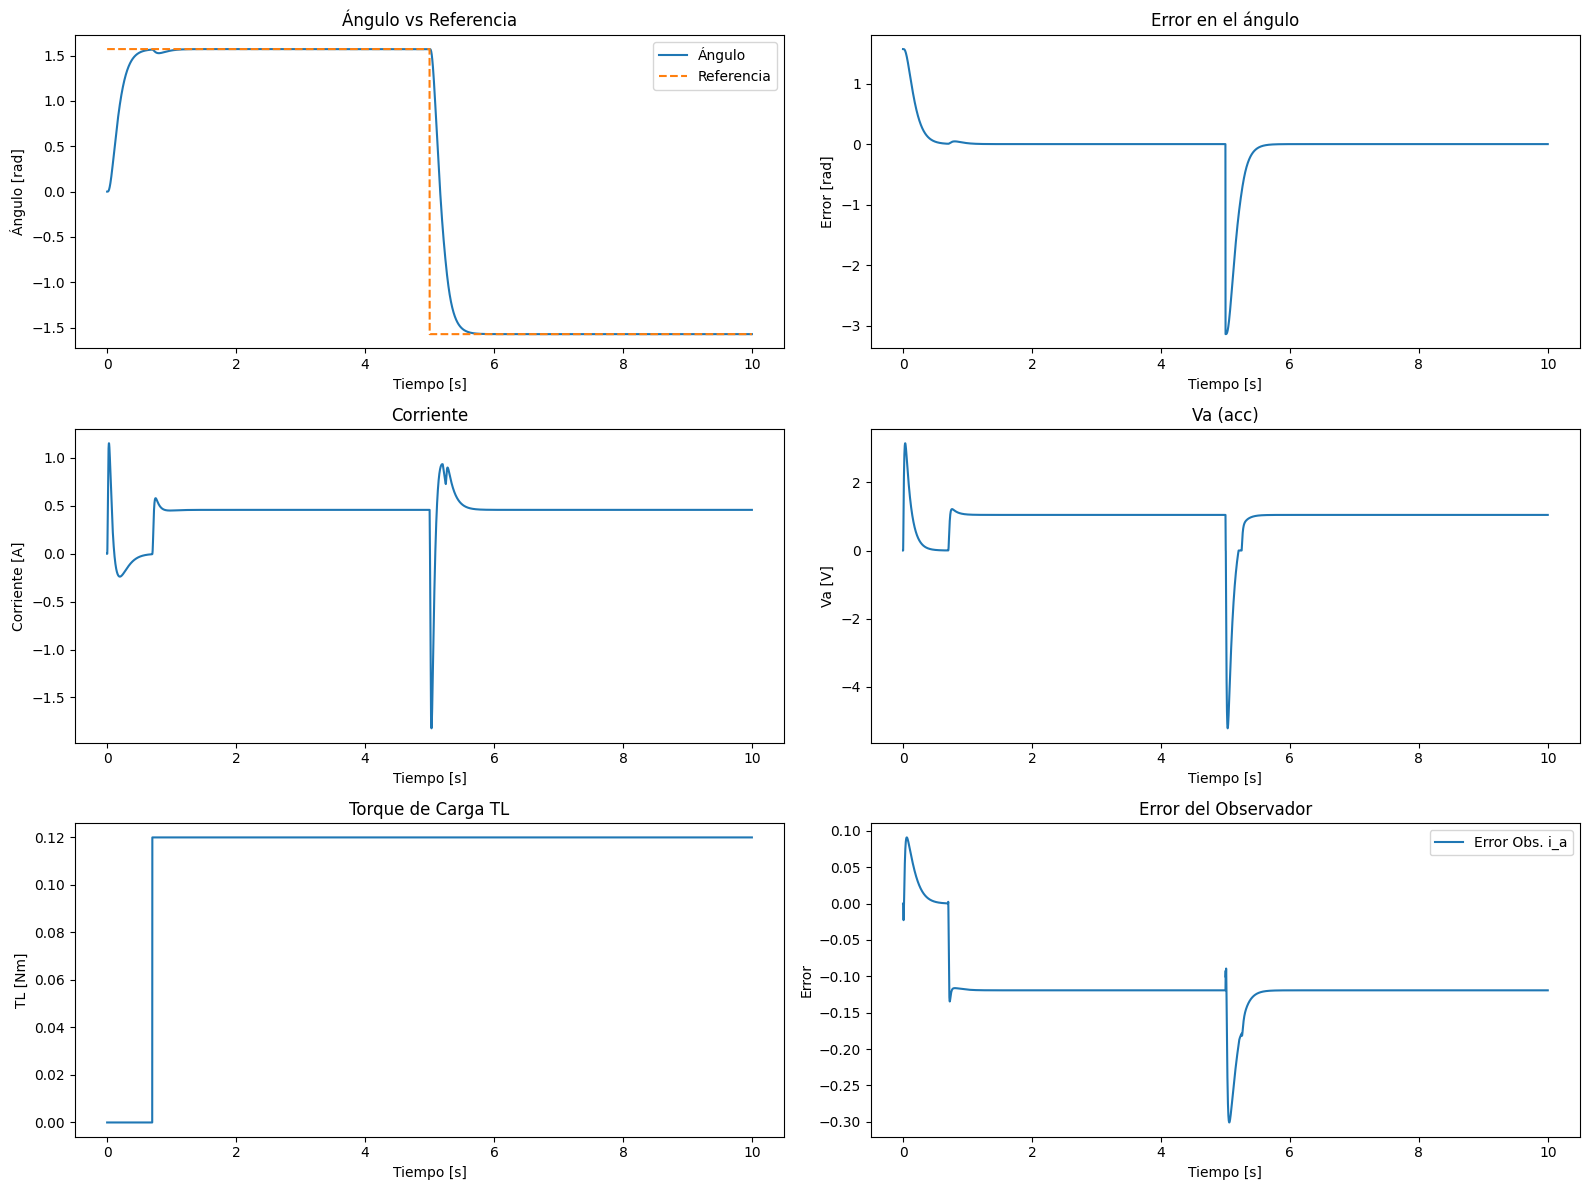

In [133]:
t = np.arange(0, t_final, dt)



# Crear las gráficas


plt.figure(figsize=(16, 12))

# Ángulo vs referencia
plt.subplot(3, 2, 1)
plt.plot(t, x3, label='Ángulo')
plt.plot(t, theta_ref_hist, label='Referencia', linestyle='--')
plt.title('Ángulo vs Referencia')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()

# Error de posición
plt.subplot(3, 2, 2)
plt.plot(t, e)
plt.title('Error en el ángulo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Error [rad]')

# Corriente
plt.subplot(3, 2, 3)
plt.plot(t, x1)
plt.title('Corriente')
plt.xlabel('Tiempo [s]')
plt.ylabel('Corriente [A]')

# Va (estado 3)
plt.subplot(3, 2, 4)
plt.plot(t, acc)
plt.title('Va (acc)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Va [V]')

# Torque de carga
plt.subplot(3, 2, 5)
plt.plot(t, TL_hist)
plt.title('Torque de Carga TL')
plt.xlabel('Tiempo [s]')
plt.ylabel('TL [Nm]')

# Error del observador
plt.subplot(3, 2, 6)
plt.plot(t, e_obs[0], label='Error Obs. i_a')
# plt.plot(t, e_obs[1], label='Error Obs. w')
# plt.plot(t, e_obs[2], label='Error Obs. theta')
plt.title('Error del Observador')
plt.xlabel('Tiempo [s]')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()

## Control Óptimo por LQR con Integrador

Para mejorar el desempeño del sistema, especialmente en presencia de perturbaciones y el seguimiento preciso de referencia, se utiliza un **regulador cuadrático lineal (LQR)**.
 

El LQR permite diseñar una ley de control óptima:

$$
u(t) = -K_{lqr} \cdot x_a(t)
$$

que minimiza el funcional de costo:

$$
J = \int_0^{\infty} \left( x_a(t)^T Q x_a(t) + u(t)^T R u(t) \right) dt
$$

donde:
- $ x_a $: vector de estado **aumentado** (con integrador),
- $ Q \geq 0 $: matriz que penaliza los errores de estado,
- $ R > 0 $: matriz que penaliza el esfuerzo de control.

Este método balancea el compromiso entre **precisión** (mediante $ Q $) y **energía aplicada** (mediante $ R $).

---

### Sistema Aumentado

Dado que el objetivo es seguir una referencia $ \theta_{\text{ref}} $, se introduce un **integrador** del error de posición:

$$
\xi(t) = \int_0^t \left( \theta_{\text{ref}}(s) - \theta_r(s) \right) ds
$$

Se construye el sistema ampliado:

$$
\begin{bmatrix}
\dot{x}(t) \\
\dot{\xi}(t)
\end{bmatrix}
=
\begin{bmatrix}
A & 0 \\
-C & 0
\end{bmatrix}
\begin{bmatrix}
x(t) \\
\xi(t)
\end{bmatrix}
+
\begin{bmatrix}
B_{va} \\
0
\end{bmatrix}
u(t)
$$

donde $ x = [i_a, \omega_r, \theta_r]^T $, y $ C = [0\quad 0\quad 1] $.

---

### Cálculo del Controlador LQR

Se define:
- $ A_a = \begin{bmatrix} A & 0 \\ -C & 0 \end{bmatrix} $,
- $ B_a = \begin{bmatrix} B_{va} \\ 0 \end{bmatrix} $

La ecuación de Riccati continua se resuelve como:

$$
A_a^T P + P A_a - P B_a R^{-1} B_a^T P + Q = 0
$$

La ganancia óptima se obtiene como:

$$
K_{lqr} = R^{-1} B_a^T P
$$

---

### Elección de Matrices $ Q $ y $ R $

La matriz $ Q $ pondera los estados, y se elige típicamente diagonal. Ejemplo:

$$
Q = \text{diag}(q_1, q_2, q_3, q_{\xi}) = \text{diag}(1,\ 10,\ 100,\ 1000)
$$

- Penaliza principalmente las desviaciones y el error acumulado del angulo $\theta$ (último estado).
- El aumento progresivo de pesos acelera el tiempo de respuesta del sistema.

La matriz $ R $ penaliza el uso de la acción de control:

$$
R = [0.01]
$$


In [119]:
Q = np.diag([1, 10, 100, 1000])  # penaliza principalmente el error (último estado)
R = np.array([[0.01]])           # penaliza el uso de voltaje


In [120]:
from scipy.linalg import solve_continuous_are


P = solve_continuous_are(A_aug, B_aug, Q, R)
K_lqr = np.linalg.inv(R) @ B_aug.T @ P

print(f"Ganancia K_lqr: {K_lqr}")





Ganancia K_lqr: [[   9.37126406   32.00162775  174.46449655 -316.22776602]]


In [121]:

# 2. Inicializar simulación
X_lqr = np.zeros((3, 1))           # Estado real
x_hat_lqr = np.zeros((3, 1))       # Estado estimado
int_error_lqr = 0                  # Integrador
TL_max = 0.12

e_lqr = np.zeros(N)
x1_lqr = np.zeros(N)
x2_lqr = np.zeros(N)
x3_lqr = np.zeros(N)
acc_lqr = np.zeros(N)
e_obs_lqr = np.zeros((3, N))
theta_ref_lqr = np.zeros(N)
TL_lqr = np.zeros(N)

# 3. Bucle de simulación
for k in range(N):
    t_actual = k * dt
    theta_ref = np.pi / 2 if t_actual <= 5 else -np.pi / 2
    TL_aplicado = TL_max if t_actual > 0.7 else 0

    y = (C @ X_lqr)[0]
    e_lqr[k] = theta_ref - y

    u = -(K_lqr @ np.vstack([x_hat_lqr, int_error_lqr]).flatten())[0]
    acc_lqr[k] = u

    # Simulación del sistema real
    entrada = np.array([[u], [TL_aplicado]])
    X_lqr = sim_motor(dt, X_lqr, entrada)

    # Observador
    x_hat_dot = A @ x_hat_lqr + B_va * u + L @ (y - C @ x_hat_lqr)
    x_hat_lqr += dt * x_hat_dot

    # Integrador
    int_error_lqr += e_lqr[k] * dt

    # Guardar resultados
    e_obs_lqr[:, k] = (X_lqr - x_hat_lqr).flatten()
    x1_lqr[k], x2_lqr[k], x3_lqr[k] = X_lqr.flatten()
    theta_ref_lqr[k] = theta_ref
    TL_lqr[k] = TL_aplicado


/tmp/ipykernel_139494/3715416460.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e_lqr[k] = theta_ref - y


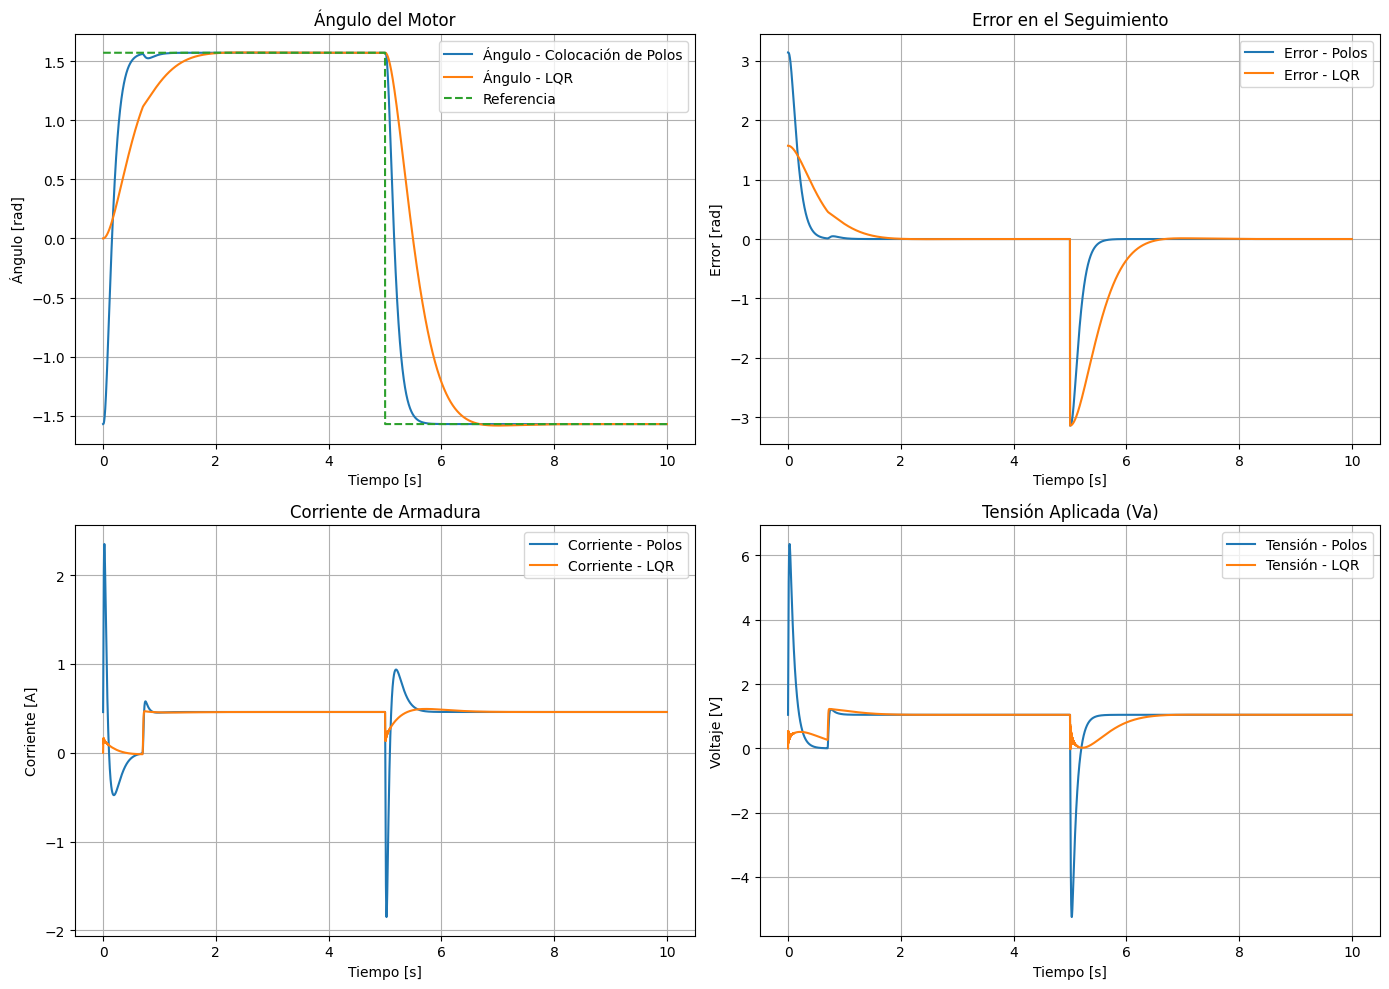

In [122]:
plt.figure(figsize=(14, 10))

# Ángulo vs Referencia
plt.subplot(2,2,1)
plt.plot(t, x3, label="Ángulo - Colocación de Polos")
plt.plot(t, x3_lqr, label="Ángulo - LQR")
plt.plot(t, theta_ref_hist, '--', label="Referencia")
plt.title("Ángulo del Motor")
plt.xlabel("Tiempo [s]")
plt.ylabel("Ángulo [rad]")
plt.legend()
plt.grid()

# Error de seguimiento
plt.subplot(2,2,2)
plt.plot(t, e, label="Error - Polos")
plt.plot(t, e_lqr, label="Error - LQR")
plt.title("Error en el Seguimiento")
plt.xlabel("Tiempo [s]")
plt.ylabel("Error [rad]")
plt.legend()
plt.grid()

# Corriente
plt.subplot(2,2,3)
plt.plot(t, x1, label="Corriente - Polos")
plt.plot(t, x1_lqr, label="Corriente - LQR")
plt.title("Corriente de Armadura")
plt.xlabel("Tiempo [s]")
plt.ylabel("Corriente [A]")
plt.legend()
plt.grid()

# Voltaje aplicado
plt.subplot(2,2,4)
plt.plot(t, acc, label="Tensión - Polos")
plt.plot(t, acc_lqr, label="Tensión - LQR")
plt.title("Tensión Aplicada (Va)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()